# RM simulator demo

This notebook is intended to demonstrate the basic usage of the RM simulator tool I wrote, and to give some basic plotting examples.

This simulator does three basic things: it lets a user create a simulated 'ideal'/physical Faraday depth function, it computes the corresponding polarization as a function of frequency, and it performs RM synthesis using a specified frequency coverage (simulating a particular observational configuration).

Note that the RM simulator uses [RM-Tools](https://github.com/CIRADA-Tools/RM-Tools/wiki) for the RM synthesis. This is easily installed with a command like `pip install RM-Tools` or using the installation instructions in the link above. You should have the rmsimulator.py file in the same directory as this notebook, or somewhere in your Python path.

Disclaimer: I originally wrote this simulator during my PhD, entirely as a project to better understand RM synthesis and to learn some very basics of object oriented programming (making a class). I present it with no warantee whatsoever, and with minimal support. If anyone has the ambition to turn it into a more sophisticated tool, I'd love to hear about it but don't have the time myself to contribute significantly.

In [13]:
import numpy as np
import rmsimulator
from matplotlib import pyplot as plt

The first step is to define the sampling: the Faraday depth region to be calculated, and the frequency coverage of the simulated observation.

There are effectively 4 parameters needed: lowest Faraday depth to compute, highest Faraday depth, step size in Faraday depth, and the frequency coverage. The frequency coverage can be one of a small number of pre-specified string (see `rmsimulator.py:set_sampling()`) or a numpy array giving the channel frequencies in Hz.

In [3]:
freq_arr=np.linspace(800.5e6,1087.5e6,288)  
#This is initially set to the POSSUM band 1 configuration: 800 to 1088 MHz, with 288 1-MHz channels

In [7]:
spectrum=rmsimulator.RMspectrum(-500,500,1,freq_arr) #This initializes the RMspectrum class object. 
#The initial values are to calculate from -500 rad/m^2 to +500 rad/m^2 in steps of 1 rad/m^2.

A freshly initialized RMspectrum object has a few key properties:
- phi: array of Faraday depth positions for the RM spectrum.
- freq: frequency array for all channels
- sampling: lambda^2 array for all channels

The second step is to add a feature to the RM spectrum. This can be a Faraday-thin peak, a Burn slab, a Gaussian, or random noise. Multiple features can be added by invoking the function more than once. Note the features can't be removed without re-initializing the spectrum from scratch.

In [15]:
spectrum.add_to_spectrum('slab',[-50,0,50,0])  #Slabs take 4 parameters: lowest Faraday depth, highest, amplitude, and polarization angle (deg)
#Note that the amplitude parameter here is for frequency-space, and represents the integrated polarized emission across the whole slab.
#The actual amplitude in the RM spectrum will be input amplitude divided by width.

In [18]:
spectrum.add_to_spectrum('peak',[200,5,30]) #Peaks take 3 parameters: Faraday depth, amplitude, and polarization angle (deg)

Adding features sets a few key properties of the spectrum object:
- idealspectrum: the physically 'true' shape of the RM spectrum, for the features that have been added. (at the positions specified by phi). See note below about normalization.
- P_lambda: array of 'measured' (complex) polarization as a function of frequency/lambda^2 for all channels
- Q_lambda: the real part of P_lambda
- U_lambda: the imaginary part of P_lambda

Once all the desired features are added, the observed RM spectrum can be computed. This adds a few more proeprties to the spectrum object: 
- spectrum: array of complex RM spectrum values (at the positions specified by phi)
- RMSF_Phi: array of Faraday depth positions for the RMSF
- RMSF: array of complex RMSF values (at the positions specified by RMSF_Phi)
- RMSF_width: width the RMSF


In [19]:
spectrum.calculate_spectrum()

Now everything is present. For plotting, the most relevant figures are either to explore the frequency domain, or to look at the Faraday depth domain:

Text(0.5, 0, '$\\lambda^2$ (m$^{2}$)')

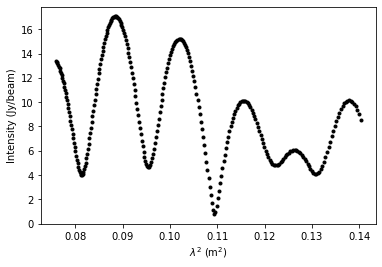

In [26]:
#Wavelength-squared domain
plt.plot(spectrum.sampling,np.abs(spectrum.P_lambda),'k.')
plt.ylabel('Intensity (Jy/beam)')
plt.xlabel('$\lambda^2$ (m$^{2}$)')
#plt.yscale('log')


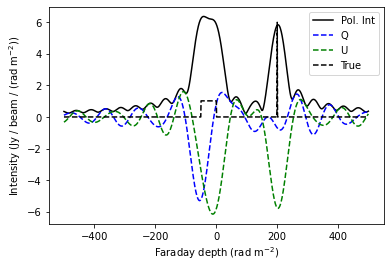

In [27]:
#Faraday depth domain
plt.plot(spectrum.phi,np.abs(spectrum.spectrum),'k-',label='Pol. Int')
plt.plot(spectrum.phi,np.real(spectrum.spectrum),'b--',label='Q')
plt.plot(spectrum.phi,np.imag(spectrum.spectrum),'g--',label='U')
plt.plot(spectrum.phi,np.abs(spectrum.idealspectrum),'k--',label='True')
plt.xlabel('Faraday depth (rad m$^{-2}$)')
plt.ylabel('Intensity (Jy / beam / (rad m$^{-2}$))')
plt.legend()

For understanding the results, it can sometimes be useful to plot the RMSF (to know what it looks like, and whether a given peak 'looks' Faraday-thin):

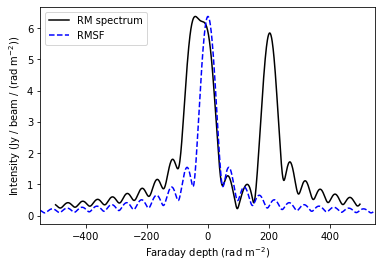

In [43]:
plt.plot(spectrum.phi,np.abs(spectrum.spectrum),'k-',label='RM spectrum')
plt.xlim(plt.xlim()) #Force axes to stay same, to avoid plotting wings of RMSF.
plt.plot(spectrum.RMSF_Phi,np.abs(spectrum.RMSF)*np.max(np.abs(spectrum.spectrum)),'b--',label='RMSF')
plt.xlabel('Faraday depth (rad m$^{-2}$)')
plt.ylabel('Intensity (Jy / beam / (rad m$^{-2}$))')
plt.legend()


One fun thing to plot is the behaviour of P_lambda over large ranges of frequency/wavelength^2.  
To do this, create one spectrum object with 'fixed' sampling (which covers a broad frequency range)
and overplot with just the sampling from a particular band of interest. Make sure all of the spectrum objects have the same features added!

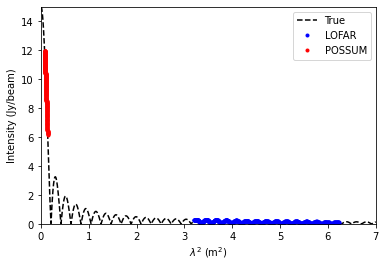

In [45]:
spectrum_LOFAR=rmsimulator.RMspectrum(-20,20,0.1,'LOTSS')
spectrum_LOFAR.add_to_spectrum('slab',[-5,10,15,0])

spectrum_fixed=rmsimulator.RMspectrum(-20,20,0.1,'fixed')
spectrum_fixed.add_to_spectrum('slab',[-5,10,15,0])

spectrum_POSSUM=rmsimulator.RMspectrum(-20,20,0.1,np.linspace(800.5e6,1087.5e6,288)  )
spectrum_POSSUM.add_to_spectrum('slab',[-5,10,15,0])

plt.plot(spectrum_fixed.sampling,np.abs(spectrum_fixed.P_lambda),'k--',label='True')
plt.plot(spectrum_LOFAR.sampling,np.abs(spectrum_LOFAR.P_lambda),'b.',label='LOFAR')
plt.plot(spectrum_POSSUM.sampling,np.abs(spectrum_POSSUM.P_lambda),'r.',label='POSSUM')
plt.ylabel('Intensity (Jy/beam)')
plt.xlabel('$\lambda^2$ (m$^{2}$)')
plt.xlim(0,7)
plt.ylim(0,15)
plt.legend()
#plt.yscale('log')